In [3]:
#!/usr/bin/env python3

import sys
srcdir = "/home/cmb-16/mjc/tsungyul/work/vntr/src/pyVNTR/"
sys.path.insert(0, srcdir)

In [186]:
%reset -f

In [1]:
import io
import os
import numpy as np
import pandas as pd

# import vntrutils as vu
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# %load_ext autoreload
# %autoreload 2

In [2]:
import pickle
import gc
import glob
# import itertools
# import gzip
# import collections
# import time
# import copy
# import random
# import sklearn.linear_model as lm
# from sklearn.neighbors import KernelDensity as KD
# from sklearn.decomposition import PCA
# from sklearn.metrics import davies_bouldin_score as DBindex, silhouette_score as SLindex
# from sklearn.metrics import mean_absolute_error as MAE
# from sklearn.cluster import AgglomerativeClustering
# # from sklearn.preprocessing import quantile_transform as qt
# import statsmodels.api as sm
# from statsmodels.stats.multitest import fdrcorrection as fdr
from scipy import stats
# from scipy.stats import beta
# import networkx as nx
# import pygraphviz
# import pysam
# import pybedtools
# import pybedtools.bedtool as bedtool
# from pybedtools import bedtool
# from pybedtools.cbedtools import Interval, create_interval_from_list
# from matplotlib.collections import LineCollection
import seaborn as sns
# from IPython.display import Image
import warnings

# warnings.filterwarnings('ignore')
np.set_printoptions(precision=2, suppress=True, edgeitems=100)

In [20]:
np.set_printoptions(precision=5, suppress=True, edgeitems=100)

In [9]:
matplotlib.rc('font', size=7)
matplotlib.rc('axes', titlesize=7)
matplotlib.rc('xtick', labelsize=5)
matplotlib.rc('ytick', labelsize=5)

In [25]:
matplotlib.rc('font', size=12)
matplotlib.rc('axes', titlesize=12)
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)

### filter by # supporting haplotypes

In [77]:
def mergeQTL(indir):
    fnames = sorted(glob.glob(f'{indir}/*.v8.egenes.txt'))
    out = None
    nrows = 0
    for f in fnames:
        tbl = np.loadtxt(f, dtype=object, ndmin=2)
        tissue = f.split("/")[-1].split(".")[0]
        if tbl.shape[0]:
            tisType = np.full([tbl.shape[0],1], tissue, dtype=object)
            tbl = np.hstack((tisType,tbl))
            out = tbl if out is None else np.vstack((out,tbl))
            nrows += tbl.shape[0]
        
    print(nrows)
    title = np.concatenate((["tissue"], np.loadtxt(f, dtype=object, comments="!", max_rows=1)[1:]))
    return out[np.argsort(out[:,-1].astype(float))], title

/home/cmb-16/mjc/tsungyul/common/Miniconda3/envs/hapdb/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/Kidney_Cortex.v8.egenes.txt"
  


2191


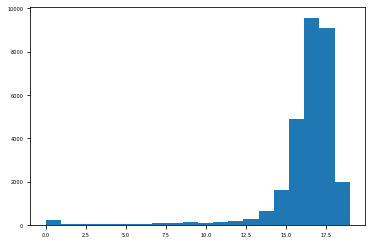

652 loci with <10 supports
         0
0        6
1        7
2        8
3        9
4       10
..     ...
647  29112
648  29113
649  29114
650  29115
651  29116

[652 rows x 1 columns]
                               0                   1               2      3  \
0                    Whole_Blood   ENSG00000168903.8           BTNL3   chr5   
1                    Whole_Blood  ENSG00000113303.11           BTNL8   chr5   
2                           Lung   ENSG00000168903.8           BTNL3   chr5   
3                        Thyroid   ENSG00000168903.8           BTNL3   chr5   
4                    Whole_Blood  ENSG00000026297.15         RNASET2   chr6   
...                          ...                 ...             ...    ...   
2186               Artery_Tibial  ENSG00000147813.15           NAPRT   chr8   
2187                      Uterus   ENSG00000215837.7          SDHAP2   chr3   
2188  Cells_Cultured_fibroblasts   ENSG00000254812.1  RP11-661A12.12   chr8   
2189                       

In [81]:
def test(indir, nloci=29111, step1csv="/home/cmb-17/mjc/vntr_genotyping/rpgg_k21_29k/output/analysis/step1.csv"):
    tbl, header = mergeQTL(indir)
#     tbl = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/fdr5/Alltissue.egenes.txt", dtype=object)    
    step1 = pd.read_csv(step1csv, sep="\t", index_col=0)
    nsup = np.zeros([nloci])
    for i in range(nloci):
        nsup[i] = np.sum(np.isfinite(step1.loc[f'tr.len.{i}']))
#     lens = np.array(step1.iloc[770:29881], dtype=float)
#     nsup = np.sum(np.isfinite(lens), axis=1)
    plt.hist(nsup, bins=20)
    plt.show(); plt.close()
    print(f'{np.sum(nsup<10)} loci with <10 supports')
    bloci = np.nonzero(nsup<10)[0] + 6 ### XXX
    print(pd.DataFrame(bloci))
    print(pd.DataFrame(tbl))
    
    mask = np.isin(tbl[:,10].astype(int), bloci) 
    print(f'{np.sum(mask)} epairs removed')
    out = tbl[~mask]
#     header = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/fdr5/Alltissue.egenes.txt", dtype=object, comments="!", max_rows=1)[1:]    
    df = pd.DataFrame(out, columns=header)
    df.to_csv(f'{indir}/Alltissue.egenes.filter.csv', sep="\t")
    
# loci with low nsup removed before eQTL mapping
# thus no pairs removed here
test("/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/")

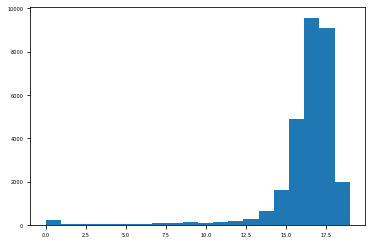

652 loci with <10 supports
1682 epairs removed


### eTR v.s. exon

In [83]:
eqtltbl = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/fdr5/Alltissue.egenes.filter.csv", dtype=object, skiprows=1)[:,1:]     

In [84]:
eqtltbl.shape

(2191, 18)

In [85]:
pd.DataFrame(eqtltbl)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Whole_Blood,ENSG00000168903.8,BTNL3,chr5,180988845,181006727,10,chr5,180986484,180986608,21968,True,True,3.6126e-72,3.6126e-72,-6.2173e-01,3.0464e-02,6.0396e-67
1,Whole_Blood,ENSG00000113303.11,BTNL8,chr5,180899077,180950906,9,chr5,180986484,180986608,21968,True,True,2.2633e-66,2.2633e-66,6.0111e-01,3.1084e-02,1.7027e-61
2,Lung,ENSG00000168903.8,BTNL3,chr5,180988845,181006727,10,chr5,180986484,180986608,21968,True,True,2.0946e-57,2.0946e-57,-6.2846e-01,3.4511e-02,4.4828e-52
3,Thyroid,ENSG00000168903.8,BTNL3,chr5,180988845,181006727,10,chr5,180986484,180986608,21968,True,True,3.6830e-56,3.6830e-56,-5.9666e-01,3.3702e-02,7.8688e-51
4,Whole_Blood,ENSG00000026297.15,RNASET2,chr6,166929504,166957184,5,chr6,166997607,166997910,23486,True,True,8.2782e-52,8.2782e-52,-5.4162e-01,3.2696e-02,2.3066e-47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,Artery_Tibial,ENSG00000147813.15,NAPRT,chr8,143574796,143578357,7,chr8,143669449,143669626,27007,True,True,3.5965e-05,3.5965e-05,1.7321e-01,4.1582e-02,4.9184e-02
2187,Uterus,ENSG00000215837.7,SDHAP2,chr3,195658096,195685904,4,chr3,195694561,195694966,18362,True,True,1.8014e-06,1.8014e-06,4.1206e-01,8.2156e-02,4.9646e-02
2188,Cells_Cultured_fibroblasts,ENSG00000254812.1,RP11-661A12.12,chr8,143632071,143633756,6,chr8,143628618,143629053,27006,True,True,3.9924e-05,3.9924e-05,1.8868e-01,4.5492e-02,4.9905e-02
2189,Liver,ENSG00000100211.10,CBY1,chr22,38656640,38673854,3,chr22,38644314,38644569,16425,True,True,1.7904e-05,1.7904e-05,3.0496e-01,6.9274e-02,4.9969e-02


In [86]:
exonTRbed = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/gtex/eqtl/tr.len.exon.isec.bed", dtype=object)

In [87]:
exonTRbed.shape

(1237, 9)

In [88]:
pd.DataFrame(exonTRbed)

,0,1,2,3,4,5,6,7,8
0,chr1,90046,90436,390,chr1,90051,90286,ENSG00000238009.6,235
1,chr1,266859,267013,154,chr1,266361,268204,ENSG00000228463.9,154
2,chr1,727184,727394,210,chr1,725885,729804,ENSG00000228327.3,210
3,chr1,853414,853904,490,chr1,853391,859446,ENSG00000228794.8,490
4,chr1,979917,980139,222,chr1,978881,981029,ENSG00000187642.9,222
...,...,...,...,...,...,...,...,...,...
1232,chrX,148547097,148547335,238,chrX,148546878,148547166,ENSG00000223516.1,69
1233,chrX,148547097,148547335,238,chrX,148547244,148547397,ENSG00000223516.1,91
1234,chrX,151672264,151672400,136,chrX,151672183,151672661,ENSG00000166049.10,136
1235,chrX,153397985,153398487,502,chrX,153395640,153398920,ENSG00000214897.4,502


In [89]:
def exonRatioStat():
    eTR = set()
    for row in eqtltbl:
        eTR.add("_".join(row[7:10]))
    exonTR = set()
    for row in exonTRbed:
        exonTR.add("_".join(row[:3]))
    exonCount = [0, 0]
    for etr in eTR:
        exonCount[int(etr in exonTR)] += 1
    r0 = exonCount[1]/sum(exonCount)
    r1 = 1237/29111
    print(f'{exonCount[1]} exon-eTR / {sum(exonCount)} eTR = {r0:.1%}')
    print(f'1237 exon-TR / 29111 TR = {r1:.1%}')
    print(f'{r0/r1:.2f}-fold enrichment')
exonRatioStat()

32 exon-eTR / 312 eTR = 10.3%
1237 exon-TR / 29111 TR = 4.2%
2.41-fold enrichment


In [94]:
# v0_wrong_proj fdr1

285 exon-eTR / 3631 eTR = 7.8%
1237 exon-TR / 29111 TR = 4.2%
1.85-fold enrichment


### VNTR length

In [126]:
def Len_AsmVsRef():
    alen = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/rpgg_k21_29k/output/analysis/step1.csv", skiprows=1, usecols=np.arange(19)+1, dtype=float)[770:29881]    
    alen = np.nanmean(alen, axis=1)
    rmask = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/rpgg_k21_29k/refGraph/output/refMap.tbl", dtype=object) != "."
    rlen = np.full(alen.size, np.nan)
    tmp = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/rpgg_k21_29k/refGraph/output/ref.bed", usecols=[1,2], dtype=float)
    rlen[rmask] = tmp[:,1] - tmp[:,0]
    eloci = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/fdr5/Alltissue.egenes.filter.csv", usecols=[11], dtype=int, skiprows=1)    
    eloci = np.sort(np.unique(eloci)) - 6
    mask = np.logical_and(np.isfinite(alen), np.isfinite(rlen))
    alen, rlen = alen[eloci][mask[eloci]], rlen[eloci][mask[eloci]]
    
    print(np.mean(alen), np.mean(rlen))
    print(stats.mannwhitneyu(alen, rlen, alternative='greater'))
    
Len_AsmVsRef()

/home/cmb-16/mjc/tsungyul/common/Miniconda3/envs/hapdb/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


714.6773771845965 623.9487179487179
MannwhitneyuResult(statistic=49510.5, pvalue=0.3548832718320877)


In [115]:
def visLen(fname):
    tbl = np.loadtxt(fname, usecols=[9,10,11], dtype=float, skiprows=1)
    elen = {}
    for start, end, locus in tbl:
        if locus not in elen:
            elen[locus] = end-start
        else:
            if end-start > elen[locus]:
                elen[locus] = end-start
    elen0 = np.array(list(elen.values()))
    elen = elen0[elen0<2000]
    
    tbl = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/gtex/eqtl/gene.100k_window.tr_clinic.pair.bed", usecols=[-3,-2,-1], dtype=object)
    vlen = {}
    for row in tbl:
        name = "_".join(row)
        start, end = int(row[1]), int(row[2])
        if name not in vlen:
            vlen[name] = end-start
        else:
            if end-start > vlen[name]:
                vlen[name] = end-start
    vlen0 = np.array(list(vlen.values()))
    vlen = vlen0[vlen0<2000]
    
    print(stats.mannwhitneyu(elen0, vlen0, alternative='greater'))
    print(f'mean eVNTR={np.mean(elen0)}, VNTR={np.mean(vlen0)}')
                
    plt.figure(figsize=(3.5,2.2), dpi=600)
    plt.hist(vlen, bins=100, color='k', label="VNTR")
    plt.hist(elen, bins=100, color='r', label="eVNTR")
#     scale = plt.axis()
#     xm = max(scale[:2])
#     plt.axis([-xm,xm,scale[2], scale[3]])
    plt.xlabel("VNTR lenth in hg38")
    plt.ylabel("Counts")
    plt.legend(fontsize=5)
    plt.show(); plt.close()

MannwhitneyuResult(statistic=4060303.5, pvalue=0.9327096581338966)
mean eVNTR=601.0288461538462, VNTR=401.30627602834807


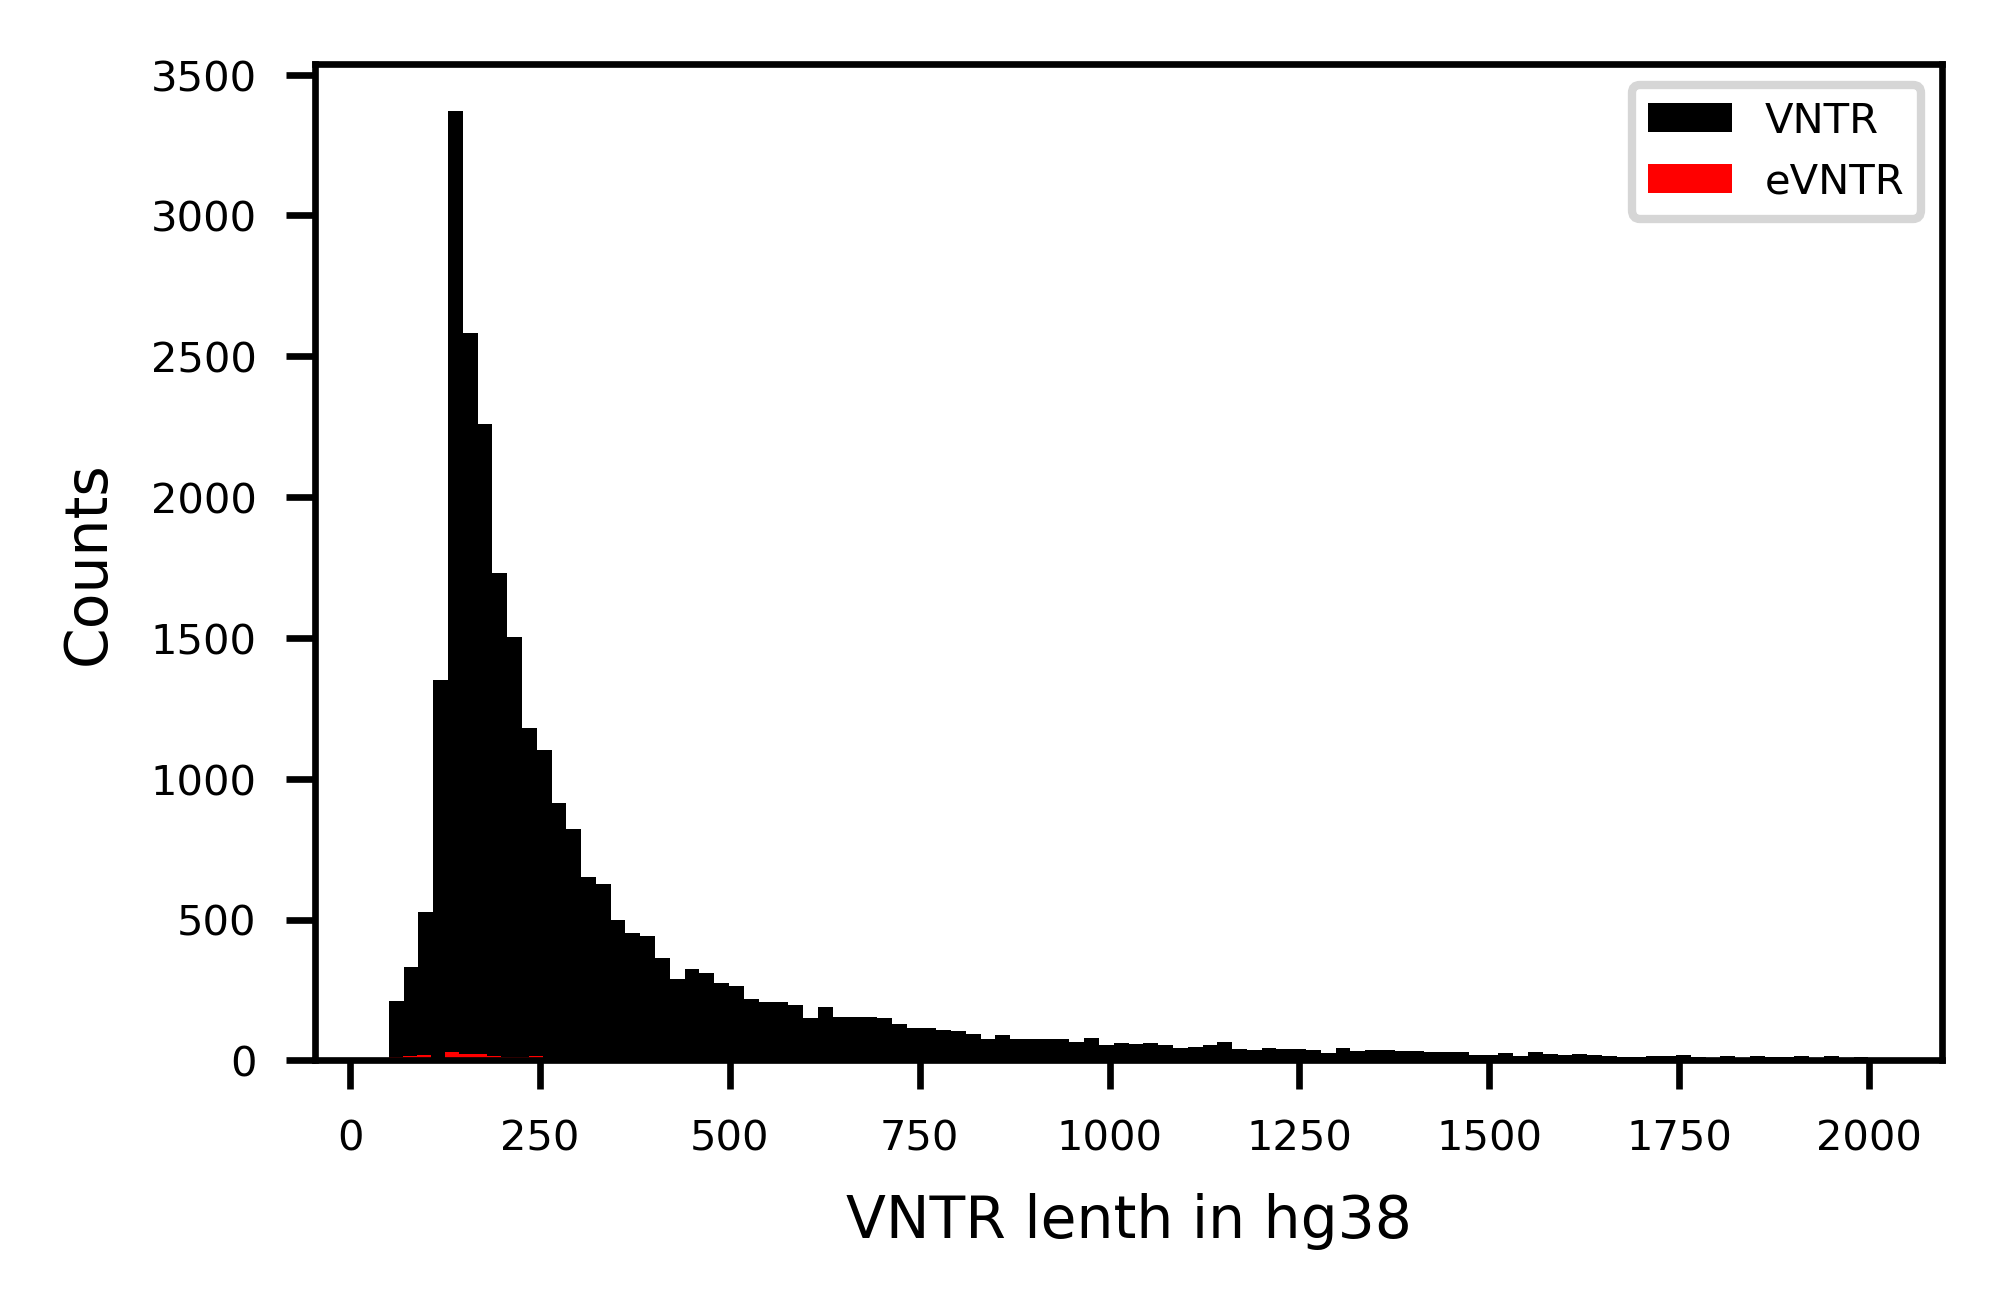

In [116]:
visLen("/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/fdr5/Alltissue.egenes.filter.csv")

### effect size

In [148]:
def visES(fname):
    tbl = np.loadtxt(fname, usecols=[11,-3], dtype=float, skiprows=1)
    bs = {}
    for locus, b in tbl:
        if locus not in bs:
            bs[locus] = b
        else:
            if abs(b) > abs(bs[locus]):
                bs[locus] = b
    bs = np.array(list(bs.values()))
    m1, m2 = bs>0, bs<0
    print(f'# pos {np.sum(m1)} neg {np.sum(m2)}')
    print(f'mean pos {np.mean(bs[m1]):.3f} neg {np.mean(bs[m2]):.3f}')
    print(f'max/min pos {np.max(bs[m1]):.3f}/{np.min(bs[m1]):.3f} neg {np.max(bs[m2]):.3f}/{np.min(bs[m2]):.3f}')
                
    plt.figure(figsize=(3.5,2.2), dpi=600)
    plt.hist(bs, bins=100, color='k')
    scale = plt.axis()
    xm = max(scale[:2])
    plt.axis([-xm,xm,scale[2], scale[3]])
    plt.xlabel("Effect size")
    plt.ylabel("Number of eVNTR")
    plt.show(); plt.close()

# pos 185 neg 127
mean pos 0.282 neg -0.245
max/min pos 0.714/0.153 neg -0.139/-0.628


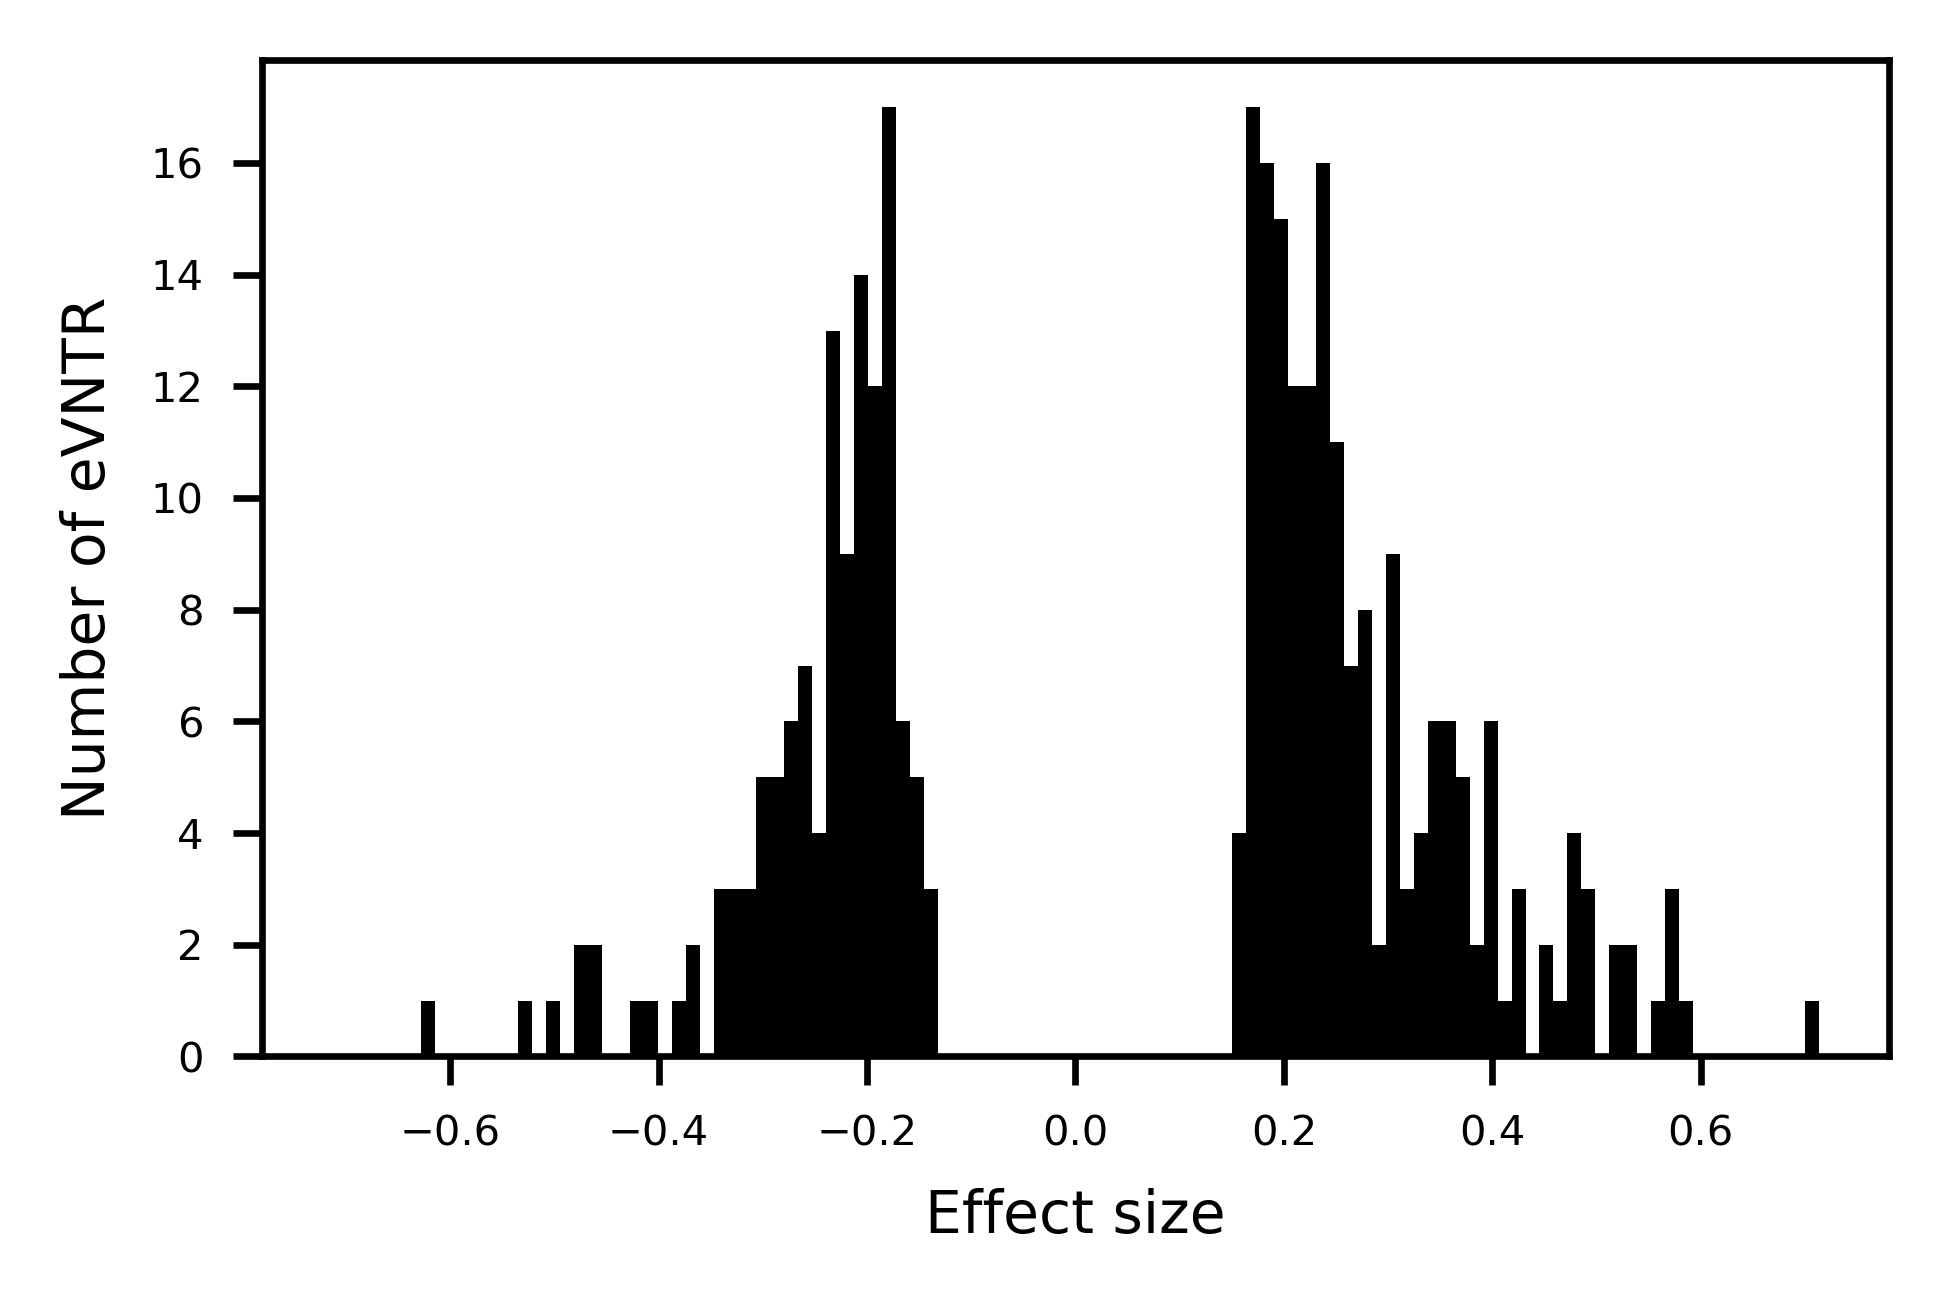

In [149]:
visES("/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/fdr5/Alltissue.egenes.filter.csv")

# pos 1471 neg 720
mean pos 0.304 neg -0.267
max/min pos 0.714/0.141 neg -0.139/-0.667


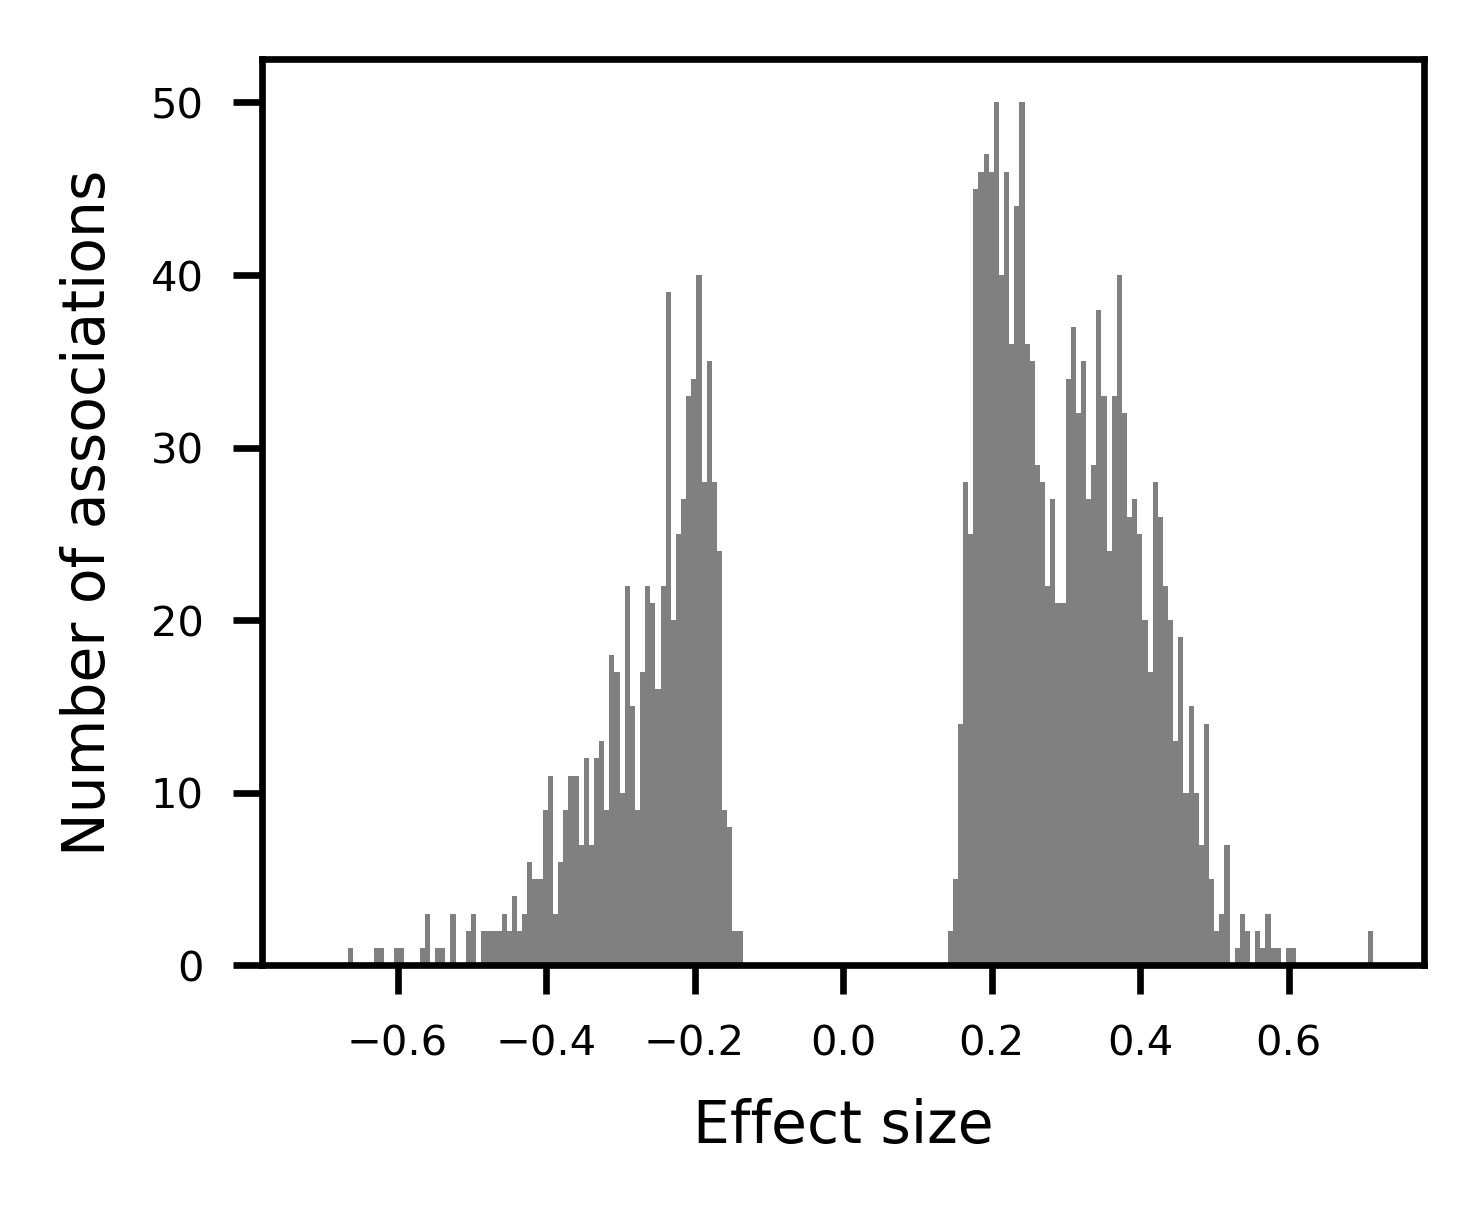

In [158]:
def visAllES(fname):
    tbl = np.loadtxt(fname, usecols=[11,-3], dtype=float, skiprows=1)
    bs = []
    for locus, b in tbl:
        bs.append(b)
    bs = np.array(bs)
    m1, m2 = bs>0, bs<0
    print(f'# pos {np.sum(m1)} neg {np.sum(m2)}')
    print(f'mean pos {np.mean(bs[m1]):.3f} neg {np.mean(bs[m2]):.3f}')
    print(f'max/min pos {np.max(bs[m1]):.3f}/{np.min(bs[m1]):.3f} neg {np.max(bs[m2]):.3f}/{np.min(bs[m2]):.3f}')
                
    plt.figure(figsize=(2.5,2), dpi=600)
    plt.hist(bs, bins=200, color='gray')
    scale = plt.axis()
    xm = max(scale[:2])
    plt.axis([-xm,xm,scale[2], scale[3]])
    plt.xlabel("Effect size")
    plt.ylabel("Number of associations")
    plt.show(); plt.close()
visAllES("/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/fdr5/Alltissue.egenes.filter.csv")

# pos 1905 neg 1726
mean pos 0.250 neg -0.225
max/min pos 0.711/0.141 neg -0.141/-0.526


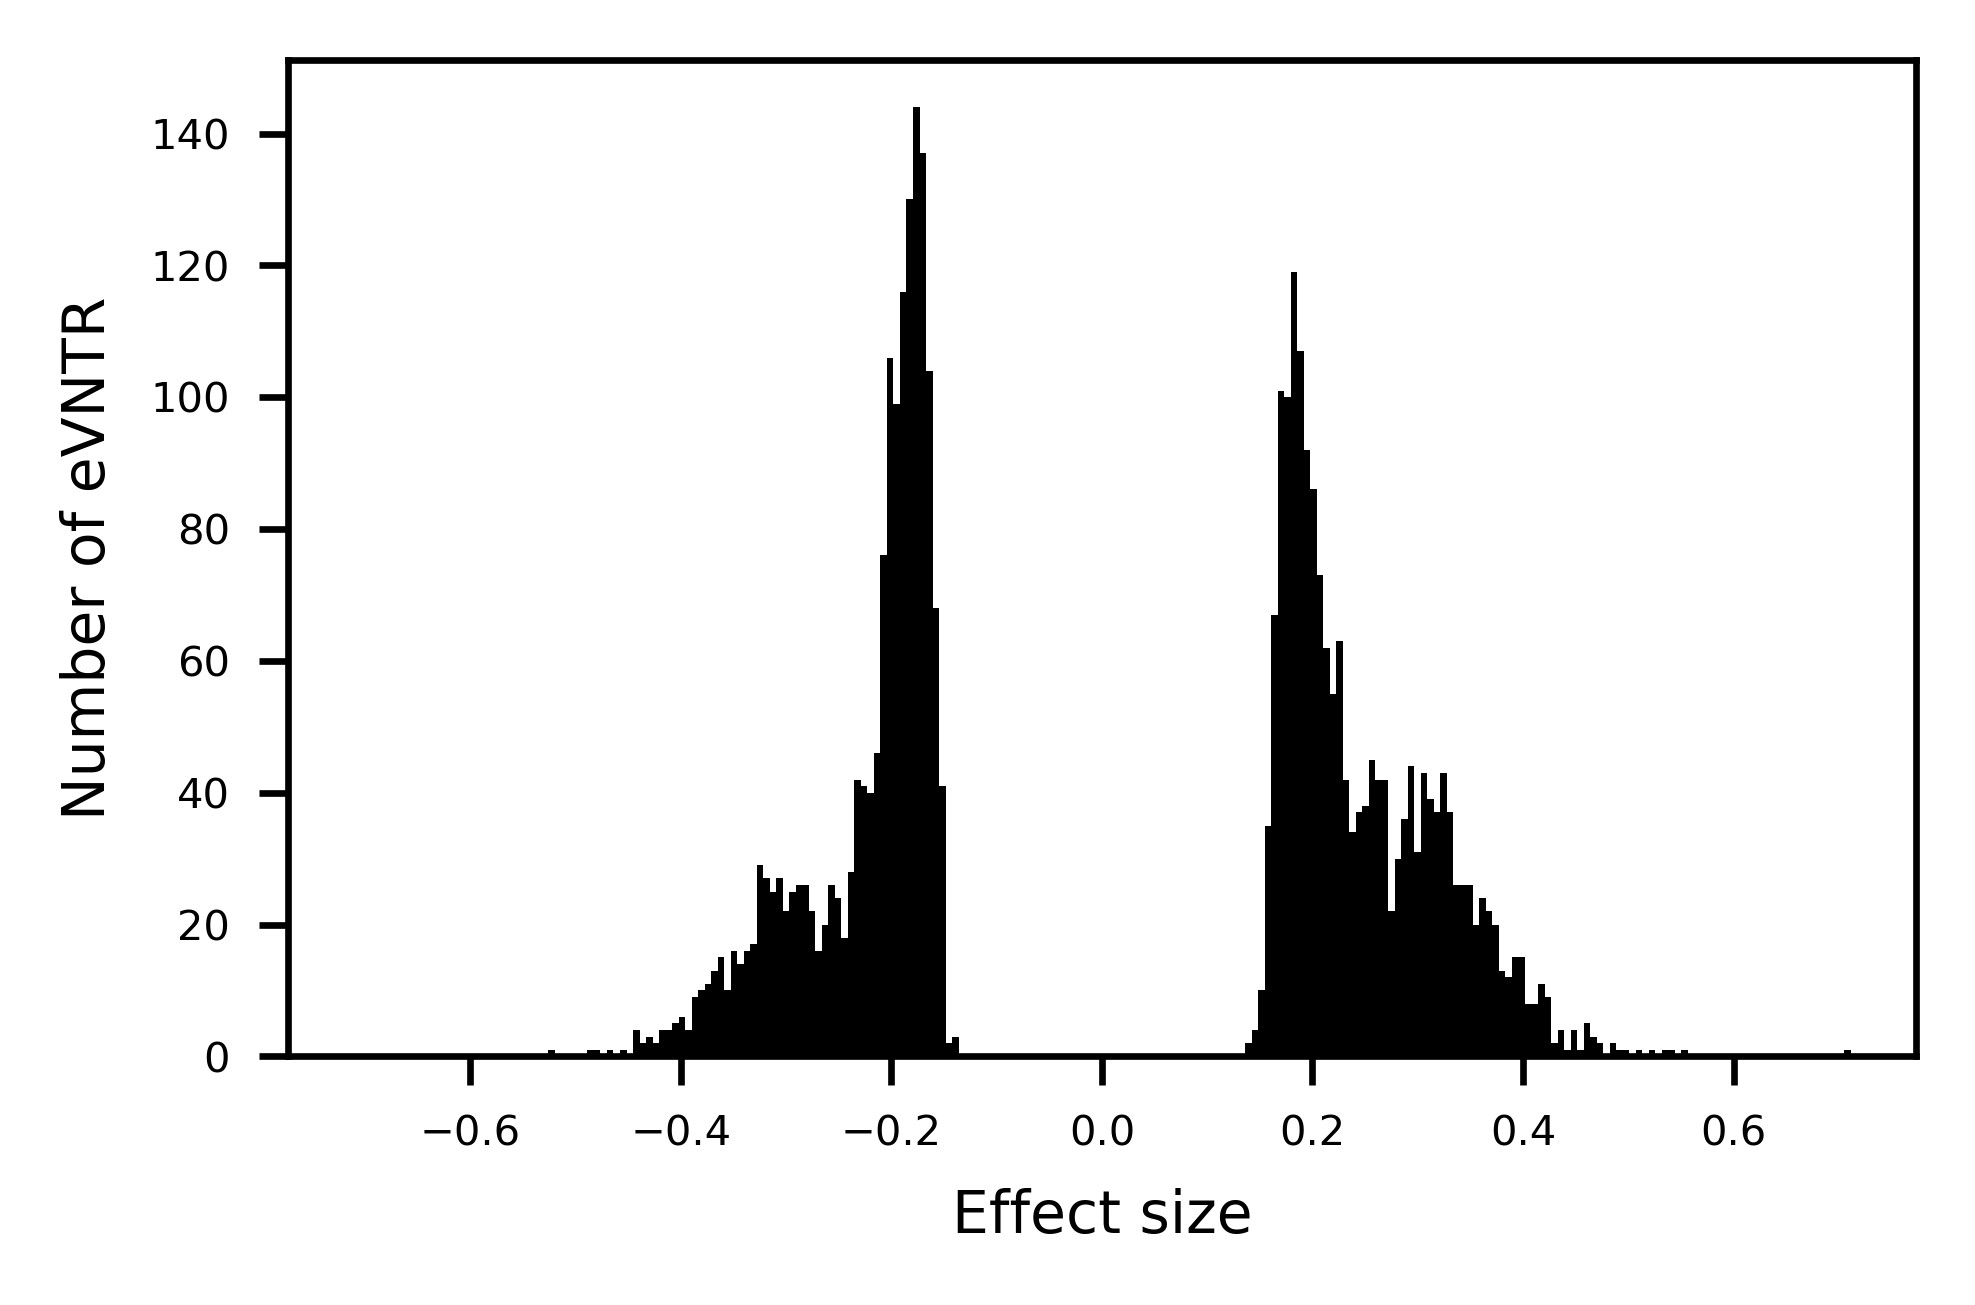

In [50]:
# v0_wrong_proj fdr1

# pos 4615 neg 2936
mean pos 0.237 neg -0.207
max/min pos 0.711/0.118 neg -0.117/-0.470


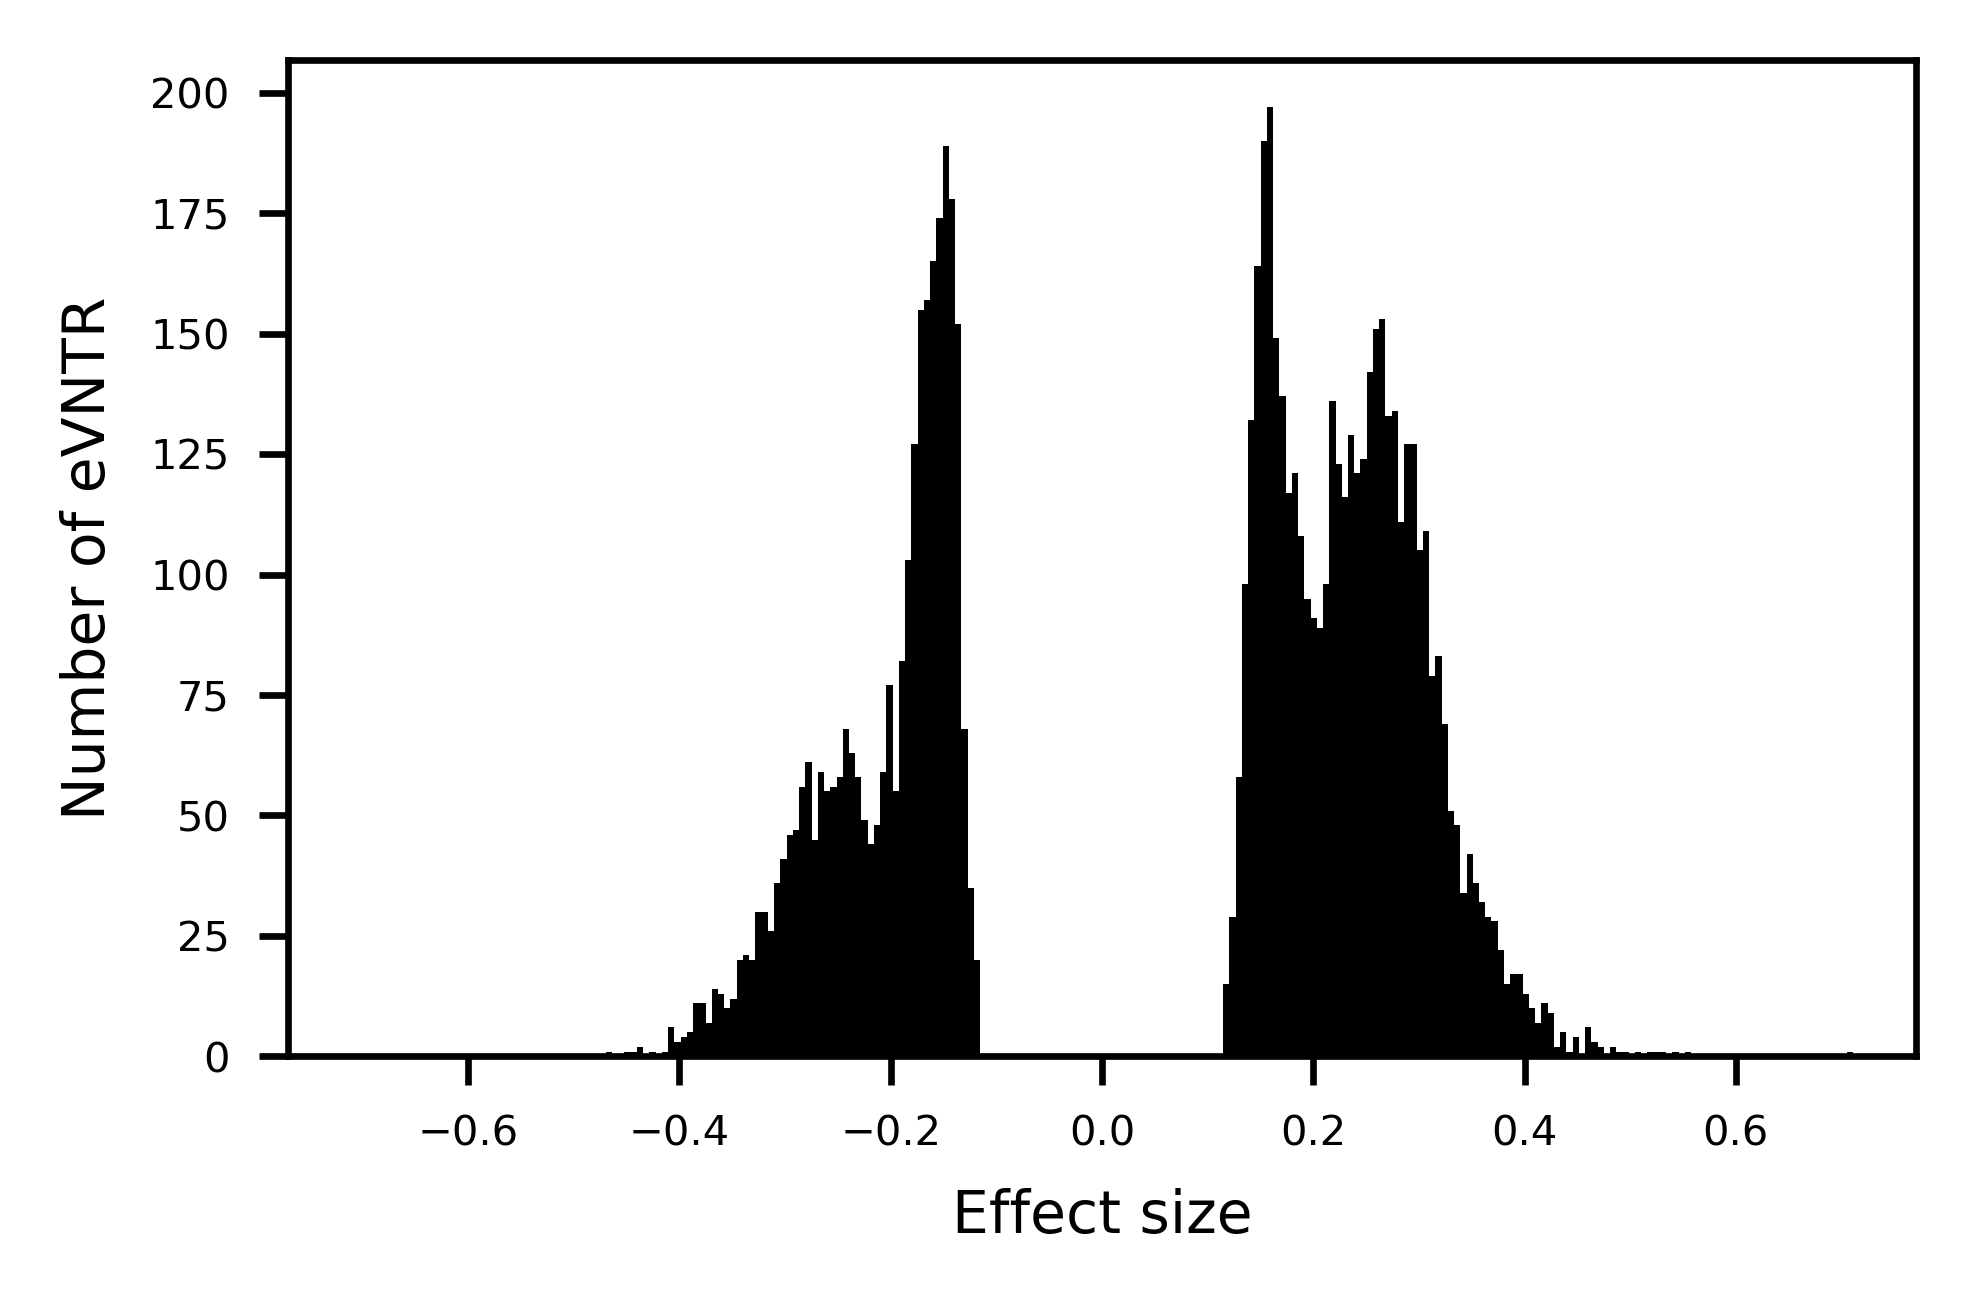

In [51]:
# v0_wrong_proj fdr5

In [132]:
def test():
    print(stats.binom_test(185, n=185+127, p=0.5))
test()

0.00121556944246752


### GC content

In [137]:
def writeEtrFasta():
    etrnames = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/analysis/eqtl/fdr5.eTR.bed", dtype=object, ndmin=2)
    etrnames = set(["/".join(row) for row in etrnames])
    with open("/home/cmb-17/mjc/vntr_genotyping/analysis/eqtl/fdr5.eTR.fasta", 'w') as fo:
        with open("/home/cmb-17/mjc/vntr_genotyping/analysis/eqtl/clinic_29k.tr.fasta") as f:
            for line in f:
                if line[0] == ">":
                    trname = line.rstrip()[1:]
                else:
                    if trname in etrnames:
                        fo.write(f'>{trname}\n')
                        fo.write(f'{line}')
writeEtrFasta()

In [138]:
def measureGC(fname):
    nuc2gc = {"A":0, "T":0, "C":1, "G":1}
    gc = [0,0]
    with open(fname) as f:
        for line in f:
            if line[0] != ">":
                line = line.strip()
                for v in line:
                    if v in nuc2gc:
                        gc[nuc2gc[v]] += 1
    print(gc[1]/sum(gc) ,gc)

In [139]:
measureGC("/home/cmb-17/mjc/vntr_genotyping/analysis/eqtl/fdr5.eTR.fasta")

0.47451351762231736 [331830, 299642]


In [54]:
measureGC("/home/cmb-17/mjc/vntr_genotyping/rpgg_k21_29k/refGraph/output/ref.tr.fasta")

0.43202716091186477 [30387116, 23113886]


In [56]:
measureGC("/home/cmb-17/mjc/vntr_genotyping/analysis/gc/input/clinic_29k.tr.fasta")

0.43203016154059715 [30392216, 23118048]


### dist to temolere

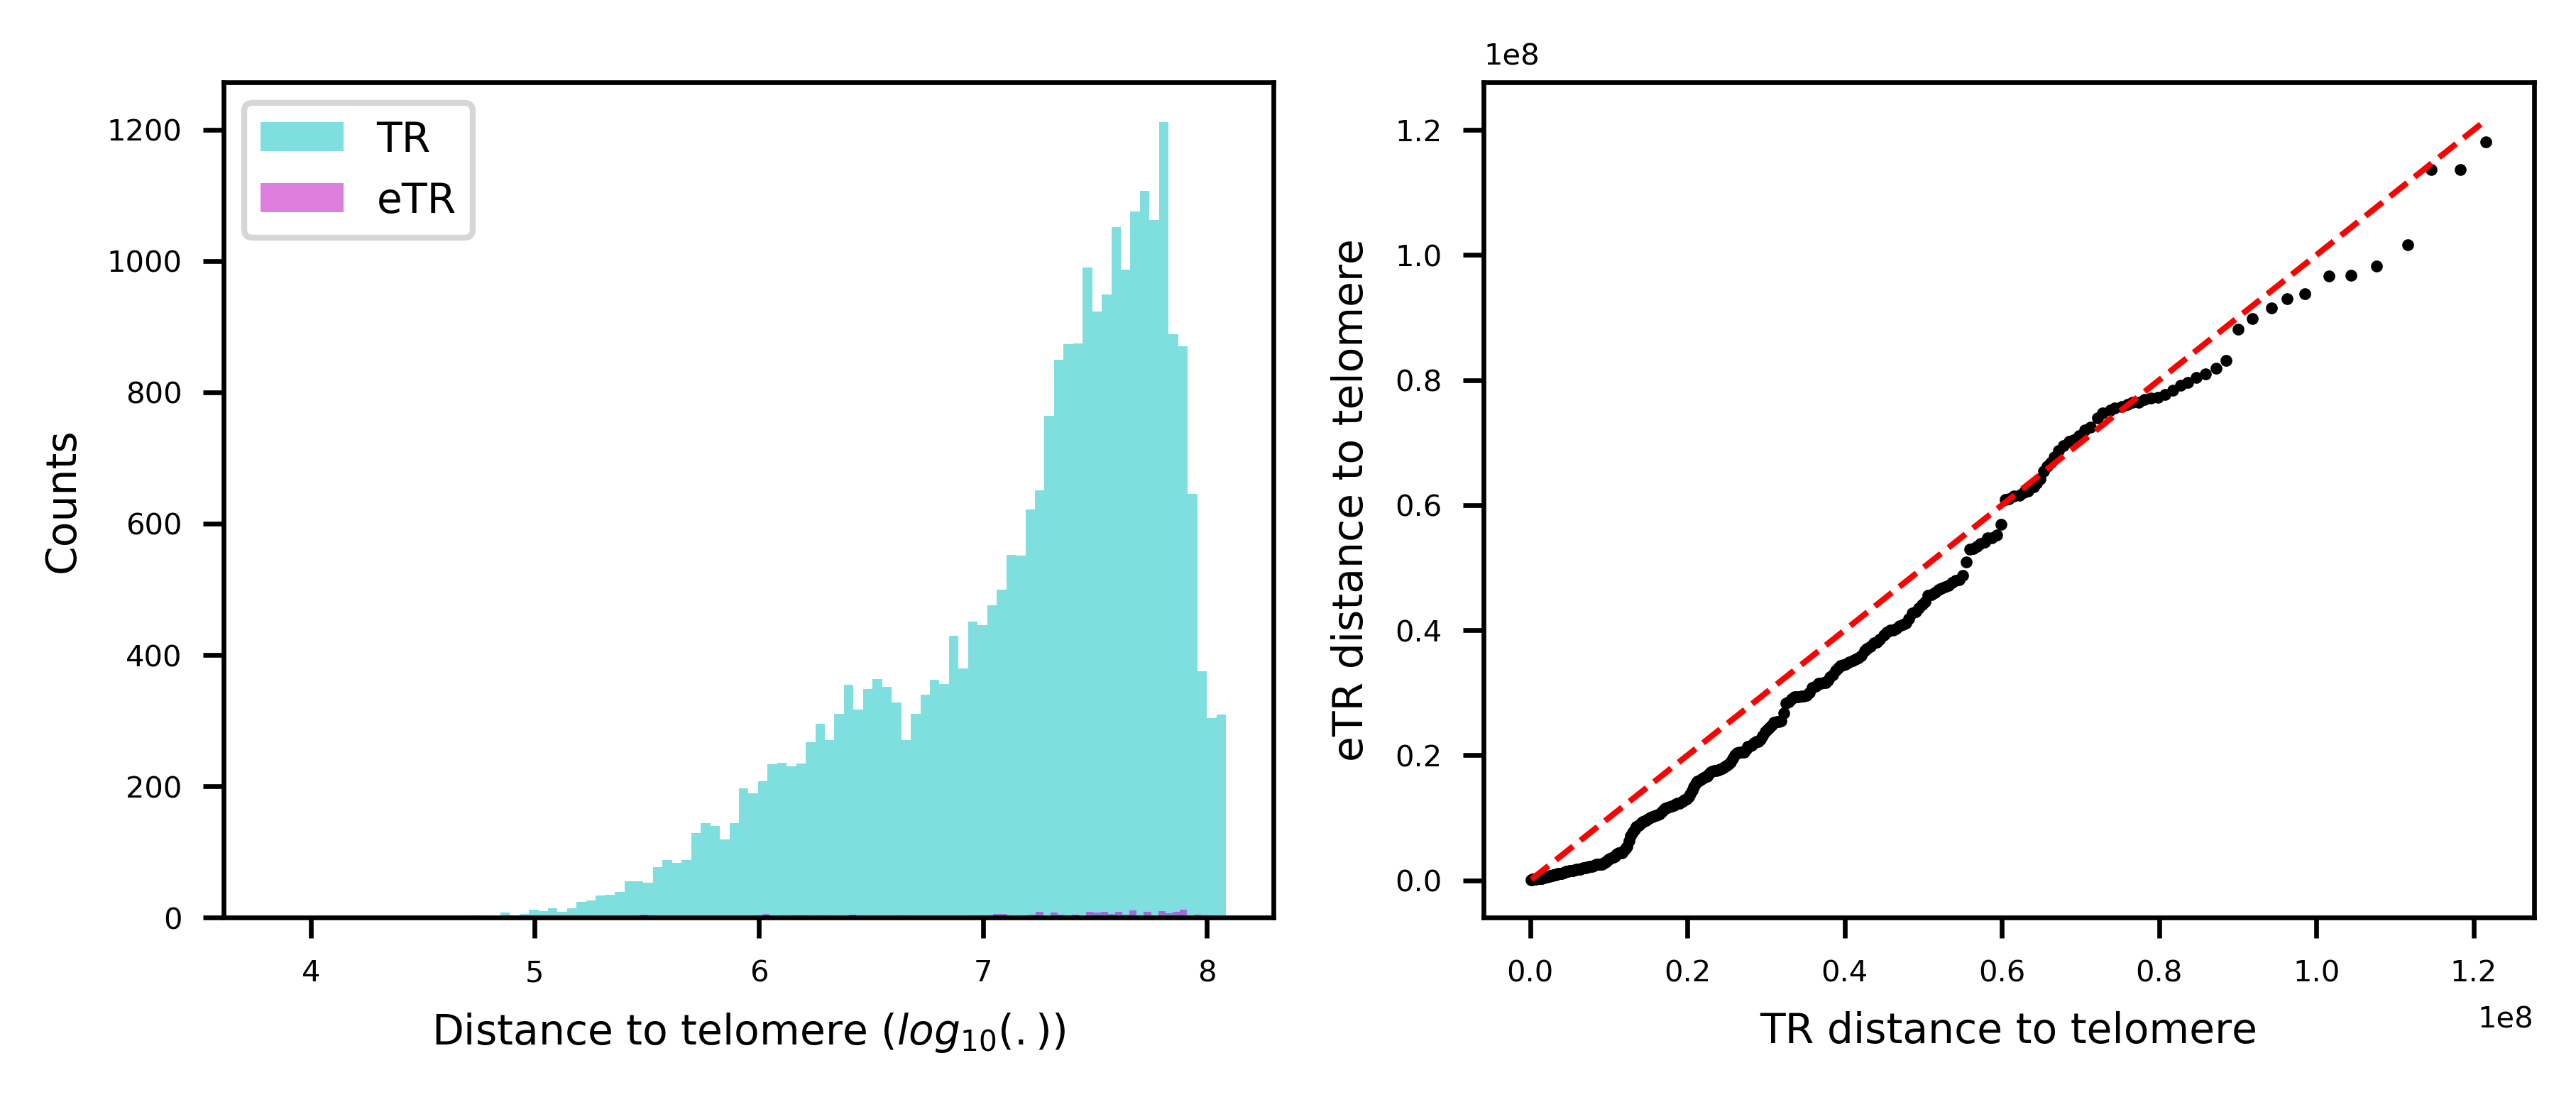

In [140]:
def test():
    tr = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/analysis/eqtl/tr.telomere.dist.bed", usecols=8, dtype=int)
    etr = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/analysis/eqtl/fdr5.eTR.telomere.dist.bed", usecols=7, dtype=int)
    tr = tr[tr>0]
    etr = etr[etr>0]
    ltr = np.log10(tr)
    letr = np.log10(etr)
    
    fig, axes = plt.subplots(1,2, dpi=600, figsize=(7,2.6))
    axes[0].hist(ltr, bins=100, color='c', alpha=0.5, label="TR")
    axes[0].hist(letr, bins=100, color='m', alpha=0.5, label="eTR")
    axes[0].set_xlabel("Distance to telomere ($log_{10}(.)$)")
    axes[0].set_ylabel("Counts")
    axes[0].legend()

    
    q = np.linspace(0,1,etr.size, endpoint=False)
    q += q[1]
    q0 = np.quantile(tr, q)
    q1 = np.quantile(etr, q)
    xmin, xmax = np.min(q0), np.max(q0)
    axes[1].plot(q0, q1, '.k', markersize=2)
    axes[1].plot([xmin, xmax], [xmin, xmax], '--r', lw=1)
    axes[1].set_xlabel("TR distance to telomere")
    axes[1].set_ylabel("eTR distance to telomere")
    plt.show(); plt.close()
    
test()

### merge all tissue eQTL (obsolete)

In [3]:
def mergeQTL(indir):
    fnames = sorted(glob.glob(f'{indir}/*.v8.egenes.txt'))
    out = None
    nrows = 0
    for f in fnames:
        tbl = np.loadtxt(f, dtype=object, ndmin=2)
        tissue = f.split("/")[-1].split(".")[0]
        if tbl.shape[0]:
            tisType = np.full([tbl.shape[0],1], tissue, dtype=object)
            tbl = np.hstack((tisType,tbl))
            out = tbl if out is None else np.vstack((out,tbl))
            nrows += tbl.shape[0]
        
    print(nrows)
    title = np.concatenate((["tissue"], np.loadtxt(f, dtype=object, comments="!", max_rows=1)[1:]))
    return out[np.argsort(out[:,-1].astype(float))], title

In [4]:
# after including clinic regions, fdr=0.05
alleQTL, alleQTL_title = mergeQTL("/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/fdr5/")

3961


/home/cmb-16/mjc/tsungyul/common/Miniconda3/envs/hapdb/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/fdr5/Kidney_Cortex.v8.egenes.txt"
  


In [5]:
np.savetxt("/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/Alltissue.egenes.txt", alleQTL, fmt='%s', delimiter="\t", header="\t".join(alleQTL_title))    

In [5]:
# v0_wrong_proj, after including clinic regions, fdr=0.05
alleQTL, alleQTL_title = mergeQTL("/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/")

19477


In [12]:
# before including clinic regions
alleQTL, alleQTL_title = mergeQTL("/home/cmb-17/mjc/vntr_genotyping/goodPanGenomeGraph/eqtl/output/v1_outlier/")

19475


In [142]:
def visShareSpecificPair(fname):
    tissues = np.array(["Lung", "Adipose_Visceral_Omentum", "Skin_Not_Sun_Exposed_Suprapubic", "Brain_Frontal_Cortex_BA9", 
                   "Artery_Aorta", "Thyroid", "Adipose_Subcutaneous", "Brain_Cerebellum", "Whole_Blood", "Muscle_Skeletal", 
                   "Artery_Tibial", "Skin_Sun_Exposed_Lower_leg", "Nerve_Tibial", "Spleen", "Small_Intestine_Terminal_Ileum", 
                   "Cells_Cultured_fibroblasts"]) 
    tisset = set(tissues.tolist())
    
    pairs = {}
    tbl = np.loadtxt(fname, usecols=[1,2,11], dtype=object, skiprows=1)
    for tissue, geneid, locusi in tbl:
        pname = (geneid,locusi)
        if pname in pairs:
            pairs[pname] = 1 # shared
        else:
            pairs[pname] = 0 # tissue-specific
        
    nshare = {}
    for tissue in tisset:
        nshare[tissue] = [0,0] # [shared, all]
        
    for tissue, geneid, locusi in tbl:
        if tissue in tisset:
            pname = (geneid,locusi)
            nshare[tissue][1] += 1
            if pairs[pname]:
                nshare[tissue][0] += 1
    
    print(nshare)
    x = np.array(["Lung", "Adipose visceral", "Skin unexposed", "Cortex", "Artery aorta", "Thyroid", "Adipose subcutaneous", 
                  "Cerebellum", "Blood", "Muscle", "Artery tibial", "Skin exposed", "Nerve", "Spleen", "Small intestine", 
                  "Fibroblasts"])    
    y0 = np.array([nshare[tissue][0] for tissue in tissues])
    y1 = np.array([nshare[tissue][1] for tissue in tissues])
    srti = np.argsort(y0/y1)
    x = x[srti]
    
    plt.figure(figsize=(2.2,1.6), dpi=600)
    plt.bar(x, y1[srti], color='m', label="Tissue-specific")
    plt.bar(x, y0[srti], color='c', label="Shared")
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xticks(rotation=45, ha='right')
    plt.legend(fontsize=5)
    plt.ylabel("Number of Pairs")
    plt.show(); plt.close()

{'Whole_Blood': [59, 92], 'Nerve_Tibial': [97, 120], 'Skin_Sun_Exposed_Lower_leg': [103, 117], 'Spleen': [34, 35], 'Brain_Frontal_Cortex_BA9': [19, 20], 'Skin_Not_Sun_Exposed_Suprapubic': [84, 100], 'Thyroid': [102, 128], 'Muscle_Skeletal': [73, 89], 'Artery_Tibial': [92, 98], 'Brain_Cerebellum': [23, 24], 'Cells_Cultured_fibroblasts': [72, 87], 'Small_Intestine_Terminal_Ileum': [24, 24], 'Lung': [85, 95], 'Adipose_Subcutaneous': [86, 91], 'Artery_Aorta': [46, 47], 'Adipose_Visceral_Omentum': [69, 72]}


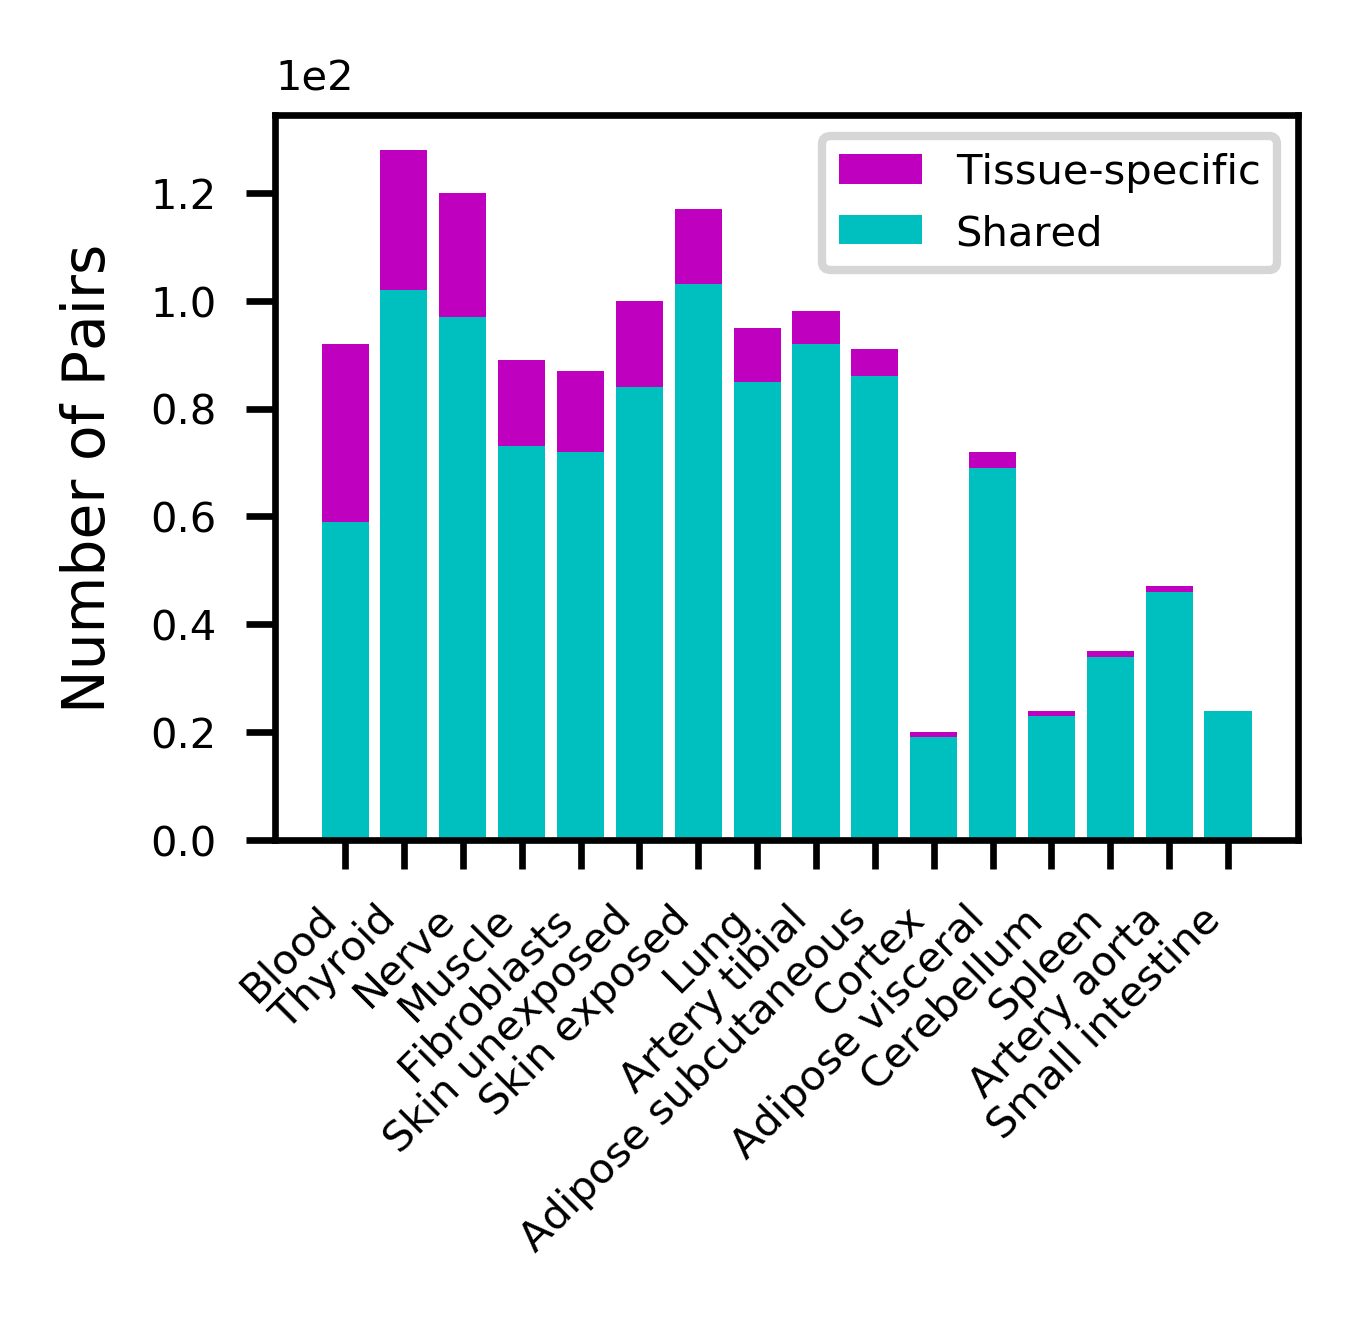

In [143]:
visShareSpecificPair("/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/fdr5/Alltissue.egenes.filter.csv")

In [146]:
def visShareSpecificTR(fname):
    tissues = np.array(["Lung", "Adipose_Visceral_Omentum", "Skin_Not_Sun_Exposed_Suprapubic", "Brain_Frontal_Cortex_BA9", 
                   "Artery_Aorta", "Thyroid", "Adipose_Subcutaneous", "Brain_Cerebellum", "Whole_Blood", "Muscle_Skeletal", 
                   "Artery_Tibial", "Skin_Sun_Exposed_Lower_leg", "Nerve_Tibial", "Spleen", "Small_Intestine_Terminal_Ileum", 
                   "Cells_Cultured_fibroblasts"]) 
    tisset = set(tissues.tolist())
    
    ### for summary statistics
    eTR = {}
    tbl = np.loadtxt(fname, usecols=[1,11], dtype=object, skiprows=1)
    for tissue, locusi in tbl:
        if locusi in eTR:
            if tissue not in eTR[locusi][1]:
                eTR[locusi][1].add(tissue)
                if eTR[locusi][0] == 0:
                    eTR[locusi][0] = 1 # shared
        else:
            eTR[locusi] = [0, set([tissue])] # tissue-specific
        
    ### for plotting
    nshare = {}
    for tissue in tisset:
        nshare[tissue] = [set(),set()] # [shared, all]
        
    for tissue, locusi in tbl:
        if tissue in tisset:
            nshare[tissue][1].add(locusi)
            if eTR[locusi][0]:
                nshare[tissue][0].add(locusi)
    
    #print(nshare)
    x = np.array(["Lung", "Adipose visceral", "Skin unexposed", "Cortex", "Artery aorta", "Thyroid", "Adipose subcutaneous", 
                  "Cerebellum", "Blood", "Muscle", "Artery tibial", "Skin exposed", "Nerve", "Spleen", "Small intestine", 
                  "Fibroblasts"])    
    y0 = np.array([len(nshare[tissue][0]) for tissue in tissues])
    y1 = np.array([len(nshare[tissue][1]) for tissue in tissues])
    srti = np.argsort(y0/y1)
    x = x[srti]
    
    plt.figure(figsize=(2.2,1.6), dpi=600)
    plt.bar(x, y1[srti], color='m', label="Tissue-specific")
    plt.bar(x, y0[srti], color='c', label="Shared")
#     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xticks(rotation=45, ha='right')
    plt.legend(fontsize=5)
    plt.ylabel("Number of eQTLs")
    plt.show(); plt.close()

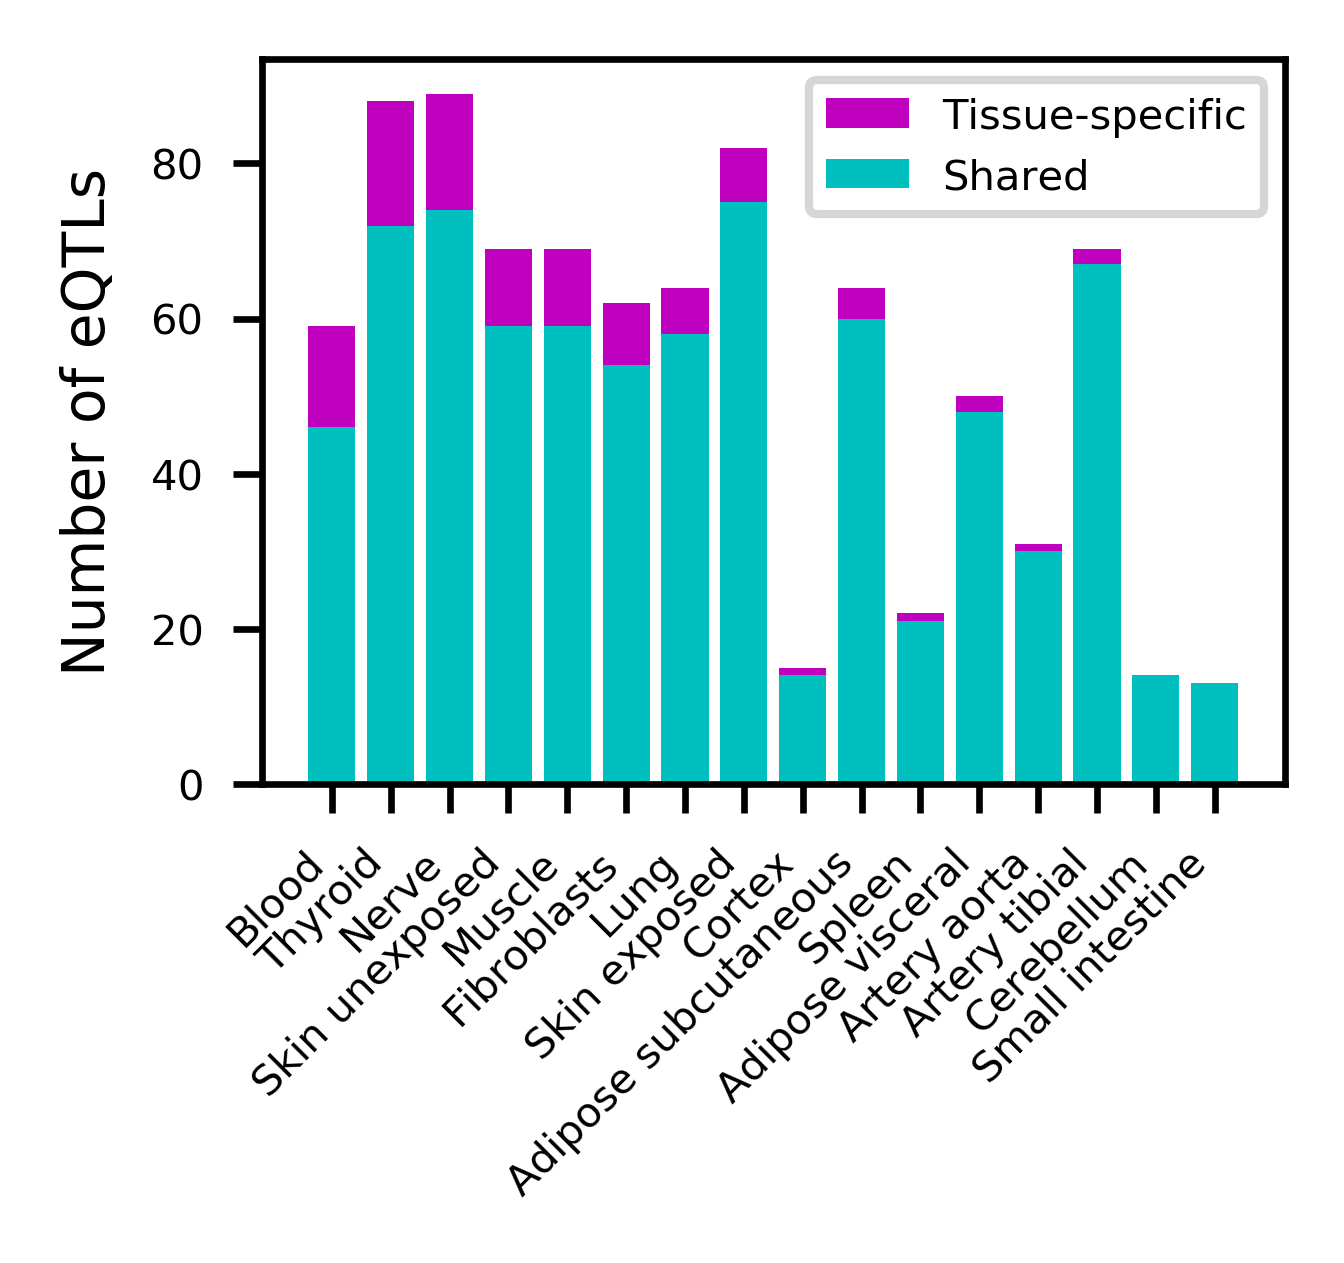

In [147]:
visShareSpecificTR("/home/cmb-17/mjc/vntr_genotyping/clinicGraph/eqtl/output/fdr5/Alltissue.egenes.filter.csv")

In [44]:
def loadePair(wd):
    tbl = np.loadtxt(f'{wd}/Alltissue.egenes.txt', usecols=[0,2,7,8,9,15], dtype=object)
    epairsi = {}
    epairs = []
    epi = 0
    for row in tbl:
        pname = (row[1], f'{row[2]}:{row[3]}-{row[4]}')
        if pname in epairsi:
            epairs[epairsi[pname]][1] += 1
        else:
            epairsi[pname] = epi
            epairs.append([pname, 1, float(row[5])>0])
            epi += 1            
    print(epi)
    return np.array(epairs)
    
epairs = loadePair("/home/cmb-17/mjc/vntr_genotyping/goodPanGenomeGraph/eqtl/output/v1_outlier")

13422


In [45]:
pd.DataFrame(epairs)

,0,1,2
0,"(YBX1P10, chr9:35999208-35999382)",36,True
1,"(CYP11B1, chr8:142976664-142977090)",10,False
2,"(SPRR2A, chr1:153003170-153003454)",8,False
3,"(KRT4, chr12:52795556-52795694)",15,False
4,"(CYP11B1, chr8:142803247-142804958)",9,False
...,...,...,...
13417,"(SNX8, chr7:2176608-2176787)",1,False
13418,"(TCEANC2, chr1:54119764-54120466)",1,False
13419,"(WSCD1, chr17:5913679-5913981)",1,False
13420,"(SOS2, chr14:50074028-50074408)",1,False


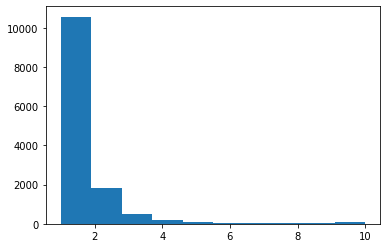

In [40]:
# number of tissue occurence for each eQTL 
def test():
    plt.hist(np.clip(epairs[:,1], 0, 10))
    plt.show(); plt.close()
test()

### eTR v.s. exon (obsolete)

In [76]:
eqtltbl = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/gtex/eqtl/noPerm/merged_muti_tissue_QTL.txt", dtype=object, skiprows=1)

In [77]:
eqtltbl.shape

(19988, 15)

In [78]:
eqtltbl[0]

array(['Adipose_Subcutaneous', 'ENSG00000279457.4', 'RP11-34P13.18',
       'chr1', '185217', '195411', '4', 'chr1', '90046', '90436', '2',
       '9.2976e-04', '1.5215e-01', '4.1075e-02', '3.7087e-02'],
      dtype=object)

In [79]:
exonTRbed = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/gtex/eqtl/tr.len.exon.isec.bed", dtype=object)

In [80]:
exonTRbed.shape

(1237, 9)

In [81]:
exonTRbed[0]

array(['chr1', '90046', '90436', '390', 'chr1', '90051', '90286',
       'ENSG00000238009.6', '235'], dtype=object)

7733 eTRs
554 eTRs in exon


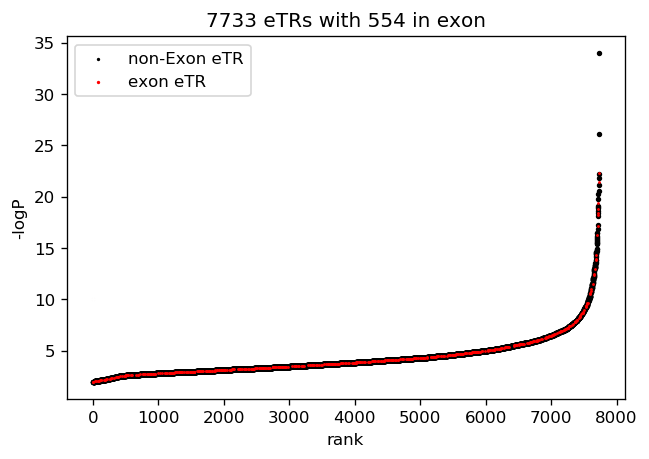

In [148]:
def test():
    #gene tr p exon
    N = eqtltbl.shape[0]
    pairs = {}
    for i in range(N):
        tr = "_".join(eqtltbl[i,7:10])
        gene = "_".join(eqtltbl[i,0:2]) # treat gene in diffrent tissue as different
        p = float(eqtltbl[i,11])
        if tr not in pairs:
            pairs[tr] = {}
        pairs[tr][gene] = p
    
    exonTRs = set()
    for row in exonTRbed:
        tr = "_".join(row[0:3])
        exonTRs.add(tr)
            
    ps = []
    exon_mask = []
    for tr, gs in pairs.items():
        if tr in exonTRs:
            exon_mask.append(True)
        else:
            exon_mask.append(False)
                
        pmin = 1
        for g, p in gs.items():
            pmin = min(pmin, p)
        ps.append(pmin)
            
             
    M = len(ps)
    ps = -np.log10(ps)
    srtidx = np.argsort(ps)
    srtps = ps[srtidx]
    srtmask = np.array(exon_mask, dtype=bool)[srtidx]
    print(f'{M} eTRs')
    print(f'{np.sum(srtmask)} eTRs in exon')
    
    x = np.arange(M)
    y = srtps
    plt.figure(dpi=120)
    plt.scatter(x[~srtmask], y[~srtmask], alpha=1, s=5, c='k')
    plt.scatter(x[srtmask], y[srtmask], alpha=1, s=0.5, c='r')
    plt.scatter(0,10, alpha=1, s=1, c='k', label="non-Exon eTR")
    plt.scatter(0,10, alpha=1, s=1, c='r', label="exon eTR")
    plt.scatter(0,10, alpha=1, s=5, c='w')
    plt.xlabel("rank")
    plt.ylabel("-logP")
    plt.title(f'{M} eTRs with {np.sum(srtmask)} in exon')
    plt.legend()
    plt.show(); plt.close()
                
    
    
test()